## Code for music chord analysis in compelx networks

### Imports

In [29]:
# nx & related
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import networkx as nx
%matplotlib inline
import pandas as pd
import altair as alt
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# drawing


# scraping
import re
import requests
from bs4  import BeautifulSoup as soup

# misc
from tqdm import tqdm
import pprint
from pychord import Chord, ChordProgression
import itertools
import pickle
import os
import glob
import time
from timeit import default_timer as timer

### Scraping code

In [2]:
def from_artist(artistname, start=1, end=1):
    # inputs link and pages, returns three lists of songs
    links = [] # no duplicates
    dirty = [] # has duplicates
    names = [] # all song names 
    for page in tqdm(range(start,end+1)):
        url = "https://www.ultimate-guitar.com/artist/"+artistname+f"?page={page}"
        s = requests.get(url)
        t = s.text
        alltext = re.findall(r'&quot;tab_url&quot;:&quot;(.*?)&quot;,&quot;',t)
        for i in alltext:
            # pro content has paywall
            if '/pro/' in i:
                continue
            dirty.append(i)
            current = re.search(r'https://tabs.ultimate-guitar.com/tab/[\w-]+/([\w-]+)-\w+-\d+',i)
            try:
                name = current.group(1)
            except:
                continue
            if name not in names:
                names.append(name)
            else:
                continue
            # ^ filtering duplicate names 
            links.append(i)
    return (links, dirty, names)

In [3]:
def chord_tonality(url):
    # gets chords and the tonality of song with url
    try:
        s = requests.get(url)
    except:
        return None, None
    m = re.search(r'{&quot;content&quot;:&quot;(.+)&quot;,&quot;revision_id&quot;',s.text)
    if m is None:
        return None, None
    tonal = re.search(r'tonality&quot;:&quot;(\w+)&quot;', s.text)
    if tonal is not None:
        tonal = re.search(r'tonality&quot;:&quot;(\w+)&quot;', s.text).group(1)
    return [re.findall(r'\[ch\]([\w#\.-]+)\[\/ch\]',m.group(1)), tonal]

In [4]:
def tofile(l, filepath):
    with open(filepath, 'w') as f:
        f.writelines([i+'\n' for i in l])

In [5]:
# format to save songs by pickle
class SongChords:
    def __init__(self, c, G):
        self.c = c
        self.G = G
    def get(self):
        return (self.c, self.G)

In [6]:
def save_song(url, folderpath, name):
    # saves song in folderpath in three different file formats
    ch, t = chord_tonality(url)
    if ch is None or len(ch) == 0:
        return None
    G = from_chords(ch)
    S = SongChords(ch, G)
    path = os.path.join(folderpath, name)
    pickle.dump(S, open(path+'.pickle','wb'))
    nx.write_gexf(G, path+'.gexf')
    nx.write_edgelist(G, path+'.edgelist')
    return 1

In [7]:
def from_chords(chords,drawsize=10, changetone=None):
    ch = zip(chords[:-1],chords[1:])
    ch =  [i for i in ch]
    G = nx.MultiDiGraph()
    G.add_edges_from(ch)
    return G

In [8]:
def convertlist(textpath, folderpath, maxlimit = 0):
    # opens file path with song url, and puts scraped songs into folderpath
    with open(textpath) as f:
        lines = f.readlines()
    lines = [i[:-1] for i in lines]
    if maxlimit == 0:
        maxlimit = len(lines)
    lines = lines[:maxlimit]
    for l in tqdm(lines):
        current = re.search(r'https://tabs.ultimate-guitar.com/tab/[\w-]+/([\w-]+)',l)
        try:
            name = current.group(1)
        except:
            continue
        nice = save_song(l, folderpath, name)

In [9]:
names = [
    'taylor_swift_16027',
]
for name in names:
    links, dirty, songs = from_artist(name,0,1)
    tofile(dirty, f'{name}-2d.txt')
    if not os.path.exists(f'./{name}-2d'): 
        os.mkdir(f'./{name}-2d')
    convertlist(f'{name}-2d.txt', f'./{name}-2d', 0)

100%|██████████| 200/200 [00:44<00:00,  4.45it/s]


### Analyzing code

In [10]:
pp = pprint.PrettyPrinter(indent=4)

In [11]:
def drawG(G, drawsize=10):
    weights = [0 for i in G.edges]
    for i,e in enumerate(G.edges):
        weights[i] =  np.log(e[2]+2)
    plt.figure(figsize=(drawsize,drawsize))
    nx.draw_networkx(G, width=weights )
    return G

In [12]:
def to_weighted(G):
    M = G.copy()
    G = nx.DiGraph()
    for u,v,data in M.edges(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if G.has_edge(u,v):
            G[u][v]['weight'] += w
        else:
            G.add_edge(u, v, weight=w)
    return G

In [13]:
def to_g(G):
    M = G.copy()
    G = nx.Graph()
    for u,v,data in M.edges(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if G.has_edge(u,v):
            G[u][v]['weight'] += w
        else:
            G.add_edge(u, v, weight=w)
    return G

In [14]:
def getsong(num):
    full = f'/Users/xieewenz/python/Networkx/ChordNetwork/*/*{str(num)}.pickle'
    s = glob.glob(full)
    if len(s)>1: 
        print('more than one match??!!')
        print(s[0])
    else:
        print(s[0])
    s = pickle.load(open(s[0],'rb'))
    return s

In [15]:
def weighted_apl_clust(G, features = ['node']):
    # a g at the end of the feature name means it converts to an unweighted graph before preforming measures
    ret = {}
    if 'apl' in features:
        ret['apl'] = nx.average_shortest_path_length(G)
    if 'apl-g' in features:
        ret['apl-g']  =  nx.average_shortest_path_length(to_g(G))
    if 'node' in features:
        ret['node'] = G.number_of_nodes()
    if 'edge' in features:
        ret['edge'] = G.number_of_edges()
    if 'edge-g' in features:
        ret['edge-g'] = to_weighted(G).number_of_edges()
    if 'clust' in features:
        ret['clust']=nx.average_clustering(to_weighted(G))
    if 'clust-g' in features:
        ret['clust-g']=nx.average_clustering(to_g(G))
    if 'pagerank-max' in features:
        ret['pagerank-max']=np.amax(list(nx.pagerank(to_weighted(G)).values()))
    if 'pagerank-max-g' in features:
        G_temp = to_weighted(G)
        G_temp.remove_edges_from(nx.selfloop_edges(G_temp))
        ret['pagerank-max-g']=np.amax(list(nx.pagerank(G_temp).values()))
    if 'pagerank-max-node' in features:
        ret['pagerank-max-node']=list(nx.pagerank(to_weighted(G)).keys())[np.argmax(list(nx.pagerank(to_weighted(G)).values()))]
    if 'pagerank-max-nodes' in features:
        pgd = nx.pagerank(to_weighted(G))
        ret['pagerank-max-nodes']={k: v for k, v in sorted(pgd.items(), key=lambda item: item[1])}
    if 'smallworld'  in features:
        ret['smallworld'] = nx.smallworld.sigma(to_g(G))
    return [ret[i] for i in features]

In [16]:
names = [
    'the_beatles_1916',
    'ramones_555', 
    'frank_sinatra_11333', 
    'linkin_park_1025',
]
features = [
    'node',
    'edge',
    'edge-g',
    'clust',
    'clust-g',
    'apl',
    'apl-g', 
    'pagerank-max', 
    'pagerank-max-g', 
    'apl-g', 
]

songcodes = []
songs = []
filelists = [f'./{n}-2d/*.edgelist' for n in names]
for fl in filelists:
    current = re.search(r'/([\w-]+)',fl)
    al = current.group(1)
    artist = glob.glob(fl)
    data = []
    for i in tqdm(artist):
        G = nx.read_edgelist(i,comments='`',create_using=nx.MultiDiGraph)
        current = re.search(r'/([\w-]+).edgelist',i)
        name = current.group(1)
        code = re.search(r'-(\d+)$',name)
        songcodes.append(code.group(1))
        songs.append([name, al]+list(weighted_apl_clust(G, features = features)))
d = np.array(songs).T
data = {
    'name':d[0],
    'artist':d[1],
}
for n, f in enumerate(features):
    data[f]=d[n+2].astype(float)
df = pd.DataFrame(data)
df.head(3)

100%|██████████| 41/41 [00:00<00:00, 61.96it/s]


,name,artist,node,edge,edge-g,clust,clust-g,apl,apl-g,pagerank-max,pagerank-max-g
0,all-you-need-is-love-chords-655700,the_beatles_1916-2d,7.0,91.0,14.0,0.552381,0.761905,1.976190,1.476190,0.324182,0.309212
1,babys-in-black-ukulele-1353495,the_beatles_1916-2d,8.0,53.0,16.0,0.239744,0.233333,2.196429,1.821429,0.338805,0.320392
2,back-in-the-ussr-ukulele-2195369,the_beatles_1916-2d,7.0,67.0,16.0,0.490842,0.523810,1.928571,1.523810,0.284259,0.280252


In [17]:
df0 = df.copy()
y = df0.pop('artist')
X = df0.drop('name', axis=1)

In [18]:
musicians = []#pd.DataFrame([{'healp':0},{'healp':1}])
m_feats = []
for n in names:
    mus = {}
    mus['name'] = n
    n = n+'-2d'
    musician_data = df.loc[df['artist'] == n]
    for f in features:
        f_data = musician_data[f]
        mus[f+'-avg'] = np.average(f_data)
        mus[f+'-sdev'] = np.std(f_data)
    musicians.append(mus)
for f in features:
    m_feats+=[f+'-avg',f+'-sdev']
df_musician = pd.DataFrame(musicians)
df_musician.head(3)

,name,node-avg,node-sdev,edge-avg,edge-sdev,edge-g-avg,edge-g-sdev,clust-avg,clust-sdev,clust-g-avg,clust-g-sdev,apl-avg,apl-sdev,apl-g-avg,apl-g-sdev,pagerank-max-avg,pagerank-max-sdev,pagerank-max-g-avg,pagerank-max-g-sdev
0,the_beatles_1916,7.913669,3.154264,64.553957,27.350686,16.417266,6.937438,0.394553,0.220315,0.504872,0.252821,2.027133,0.461251,1.628742,0.360051,0.315936,0.091975,0.289667,0.075948
1,ramones_555,8.809524,5.067347,173.158730,170.473403,33.857143,34.117378,0.472286,0.195279,0.621962,0.226548,1.814271,0.364125,1.525470,0.283464,0.271996,0.104929,0.264590,0.094346
2,frank_sinatra_11333,17.130137,8.059933,77.000000,34.859994,35.143836,19.979095,0.175844,0.120356,0.288502,0.170827,3.207123,0.863267,2.217591,0.513907,0.173698,0.060798,0.168162,0.055945


In [19]:
# bar graph
selection = alt.selection_multi(fields=['artist',])
color = alt.condition(selection, alt.Color('artist:N', legend=None),alt.value('lightgray'))
bars = alt.Chart(df).mark_bar().encode(
    x='artist:O',
    color=color,
    tooltip='artist'
).interactive()
error_bars = alt.Chart(df).mark_errorbar(extent='ci').encode(
    x='artist:O',
)
res = bars.encode(y=f'mean({features[0]}):Q')+error_bars.encode(y=f'{features[0]}:Q')
for i in features[1:]:
    res = res|bars.encode(y=f'mean({i}):Q')+error_bars.encode(y=f'{i}:Q')
alt.Chart(df).mark_rect().encode(y='artist', color=color).add_selection(selection) | res

alt.HConcatChart(...)

In [20]:
#node vs. edge & apl vs. clust
# drag to select
selection = alt.selection_interval() 
color = alt.condition(selection, alt.Color('artist:N', legend=None),alt.value('lightgray'))
make_selector = alt.Chart(df).mark_rect().encode(y='artist', color=color).add_selection(selection)
opacity = alt.condition(selection, alt.value(1.0), alt.value(0.1))
chart = alt.Chart(df).mark_circle(size=10).encode(color=color, opacity = opacity,tooltip=['name', 'artist']+features,
).add_selection(selection)
make_selector|chart.encode(x=features[0],y=features[1]) | chart.encode(x=features[2],y=features[3]) 

alt.HConcatChart(...)

In [22]:
def drawsubG(G, drawsize=10, sub=111):
    weights = [0 for i in G.edges]
    for i,e in enumerate(G.edges):
        weights[i] =  np.log(e[2]+2)
    plt.subplot(sub)
    nx.draw_networkx(G, width=weights,with_labels=True )#, font_size=20, node_color='#F2C665',node_size=500)
    return G

more than one match??!!
/Users/xieewenz/python/Networkx/ChordNetwork/general-big-2d/babys-in-black-ukulele-1353495.pickle
{   'apl': 2.1964285714285716,
    'apl-g': 1.8214285714285714,
    'clust': 0.23974358974358975,
    'clust-g': 0.23333333333333334,
    'edge': 53,
    'edge-g': 16,
    'node': 8,
    'pagerank-max': 0.33880484760874413,
    'pagerank-max-g': 0.3203923972166813,
    'pagerank-max-node': 'A',
    'pagerank-max-nodes': {   'A': 0.33880484760874413,
                              'A7': 0.059890299685184896,
                              'B7': 0.04634412997317826,
                              'D': 0.2079882460424436,
                              'D7': 0.03344506122149729,
                              'E': 0.07360373291357986,
                              'E7': 0.20746024932697696,
                              'F#m': 0.03246343322839497}}
more than one match??!!
/Users/xieewenz/python/Networkx/ChordNetwork/general-big-2d/all-you-need-is-love-chords-655700.pickle
{

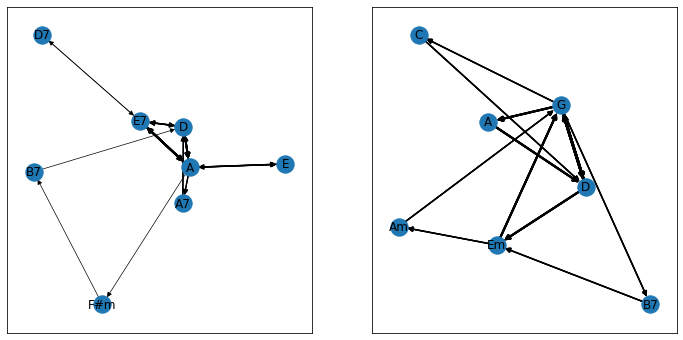

In [24]:
snum = songcodes[1]
plt.figure(figsize=(12,6))
G_an = drawsubG(getsong(snum).get()[1],drawsize=6,sub=121)
feat_res = weighted_apl_clust(G_an, features[:-1]+['pagerank-max-node','pagerank-max-g','pagerank-max-nodes'])
f = {i:j for i,j in zip( features[:-1]+['pagerank-max-node','pagerank-max-g','pagerank-max-nodes'], feat_res)}
pp.pprint(f)
snum2 = songcodes[0]
G_an = drawsubG(getsong(snum2).get()[1],drawsize=6,sub=122)
feat_res = weighted_apl_clust(G_an, features[:-1]+['pagerank-max-node','pagerank-max-g','pagerank-max-nodes'])
f = {i:j for i,j in zip( features[:-1]+['pagerank-max-node','pagerank-max-g','pagerank-max-nodes'], feat_res)}
pp.pprint(f)

%store G_an
%store f

beginnn
Classification score 0.7199165175909362 (pvalue : 0.009900990099009901)
Luck:  0.25
Classification Score:  0.7199165175909362
Permutation Score 0.36249433512224216


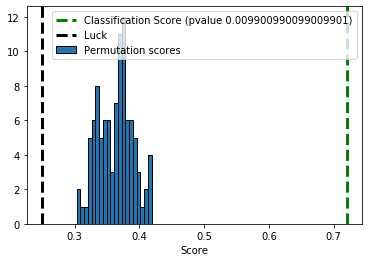

In [31]:

n_permutations = 100
n_classes = np.unique(y).size


clf = make_pipeline(StandardScaler(),
                    LinearSVC( tol=1e-5, max_iter=19000, dual=False))
cv = StratifiedKFold(3)
print('beginnn')
score, permutation_scores, pvalue = permutation_test_score(
    clf, X, y, scoring="accuracy", cv=cv, n_permutations=n_permutations, n_jobs=-1,)
print("Classification score %s (pvalue : %s)" % (score, pvalue))
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')

print('Luck: ',1. / n_classes)
print('Classification Score: ',score)
print('Permutation Score',np.average(permutation_scores))
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()